In [1]:
import os

In [2]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.4 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

## 1. Download images

In [4]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('football', max_images=1)
urls[0]

Searching for 'football'


'https://nwscdn.com/media/catalog/product/t/r/training_football_in_orange.jpg'

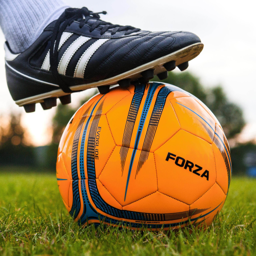

In [6]:
from fastdownload import download_url
dest = 'football.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'hockey picture'


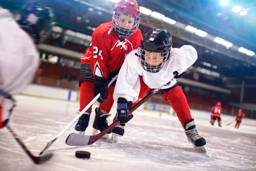

In [7]:
download_url(search_images('hockey picture', max_images=1)[0], 'hockey.jpg', show_progress=False)
Image.open('hockey.jpg').to_thumb(256, 256)

In [8]:
searches = 'football', 'hockey'
path = Path('sports_classifier')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{o} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"{o} team"))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'football photo'
Searching for 'football team'
Searching for 'hockey photo'
Searching for 'hockey team'


## 2. Train model

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.515501,2.286812,0.523810,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.497756,0.889925,0.333333,00:01
1,0.518808,0.328368,0.095238,00:00
2,0.372738,0.292078,0.095238,00:00
3,0.295661,0.252891,0.047619,00:01
4,0.236132,0.223536,0.047619,00:01
5,0.193102,0.203097,0.047619,00:00


In [12]:
is_football,_,probs = learn.predict('football.jpg')
print(f"This is a {is_football} picture")
print(f"Probability it's a football picture: {probs[0]:.4f}")

This is a football picture
Probability it's a football picture: 0.8574


In [13]:
is_hockey,_,probs = learn.predict('hockey.jpg')
print(f"This is a {is_hockey} picture")
print(f"Probability it's a hockey picture: {1-probs[0]:.4f}")

This is a hockey picture
Probability it's a hockey picture: 1.0000
